In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import anndata as ad
import scanpy as sc

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from umap import UMAP

from scroutines import powerplots

import importlib
importlib.reload(powerplots)
from scroutines import basicu
from scroutines.miscu import is_in_polygon

import utils_merfish

In [2]:
np.random.seed(0)

In [3]:
# functions (the teacher wrote for you to use later)
def rot2d(x, y, theta, unit='degree'):
    """ rotate data points defined by `x` and `y` by `theta` degree
    """
    a = np.vstack([x,y]).T
    if unit == 'degree':
        theta = theta*np.pi/180 # convert to radian

    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    ar = a.dot(R.T)
    return ar[:,0], ar[:,1]

def st_scatter(x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', output='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    fig, ax = plt.subplots(figsize=(10,8))
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    if output:
        powerplots.savefig_autodate(fig, output)
        
    return 

def st_scatter_ax(ax, x, y, gexp=None, vmax_p=98, unit_norm=False, 
               title='', s=1, cbar_label='', cmap='rocket_r', axis_off=True, 
               vmin=None, **cbar_kwargs):
    """customized scatter plot -- yesterday's progress
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable
  
    if gexp is not None:
        vmax = np.percentile(gexp, vmax_p)
        if unit_norm:
            rgexp = gexp/vmax
            g = ax.scatter(x, y, c=rgexp, s=s, edgecolor='none', vmin=vmin, vmax=1, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
            title = title + f" (max {vmax:.2g} at {vmax_p:.2g} pctl)"
        else:
            g = ax.scatter(x, y, c=gexp, s=s, edgecolor='none', vmin=vmin, vmax=vmax, cmap=cmap, rasterized=True)
            fig.colorbar(g, label=cbar_label, shrink=0.3, **cbar_kwargs)
    else:
        g = ax.scatter(x, y, s=s, edgecolor='none', cmap=cmap, rasterized=True)
  
    if axis_off:
        ax.axis('off')
    ax.set_title(title)
    ax.set_aspect('equal')
  
    return 

# visualize clusters
def plot_cluster(clsts, x, y, ux, uy, s=1, axis_off=True):
    """this assumes `clsts` is a integer that starts from 0
    """
    from matplotlib import colors
  
    unq_clsts, inv = np.unique(clsts, return_inverse=True)
    n_unq = len(unq_clsts)
    # colors = np.array(sns.color_palette('husl', n_unq))
    # c_vec = colors[inv]
  
    cmap = plt.cm.jet
    norm = colors.BoundaryNorm(np.arange(-0.5, n_unq, 1), cmap.N)
  
    fig, axs = plt.subplots(1, 2, figsize=(8*2,6))
    
    ax = axs[0]
    g = ax.scatter(x, y, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('XY (spatial distribution)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
    
    ax = axs[1]
    ax.scatter(ux, uy, norm=norm, cmap=cmap, c=clsts, s=s, edgecolor='none')
    ax.set_title('UMAP (molecular similarity)')
    ax.set_aspect('equal')
    if axis_off:
        ax.axis('off')
  
    fig.colorbar(g, ax=ax, label='clusters', ticks=np.arange(n_unq), shrink=0.7)
    return fig, axs

In [4]:
outdir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/plots_240228"
outdatadir = "/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish"
!mkdir -p $outdir

In [5]:
adata = ad.read('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/pos_reg1_ctxglut_230719.h5ad')
adata = adata[adata.obs['x'] > 7000]
adata

View of AnnData object with n_obs × n_vars = 15669 × 500
    obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'leiden_r0.2', 'leiden_spatial_r0.02', 'leiden_r0.5'
    uns: 'leiden', 'neighbors'
    obsm: 'blanks', 'pca', 'umap', 'xy'
    layers: 'norm'
    obsp: 'connectivities', 'distances'

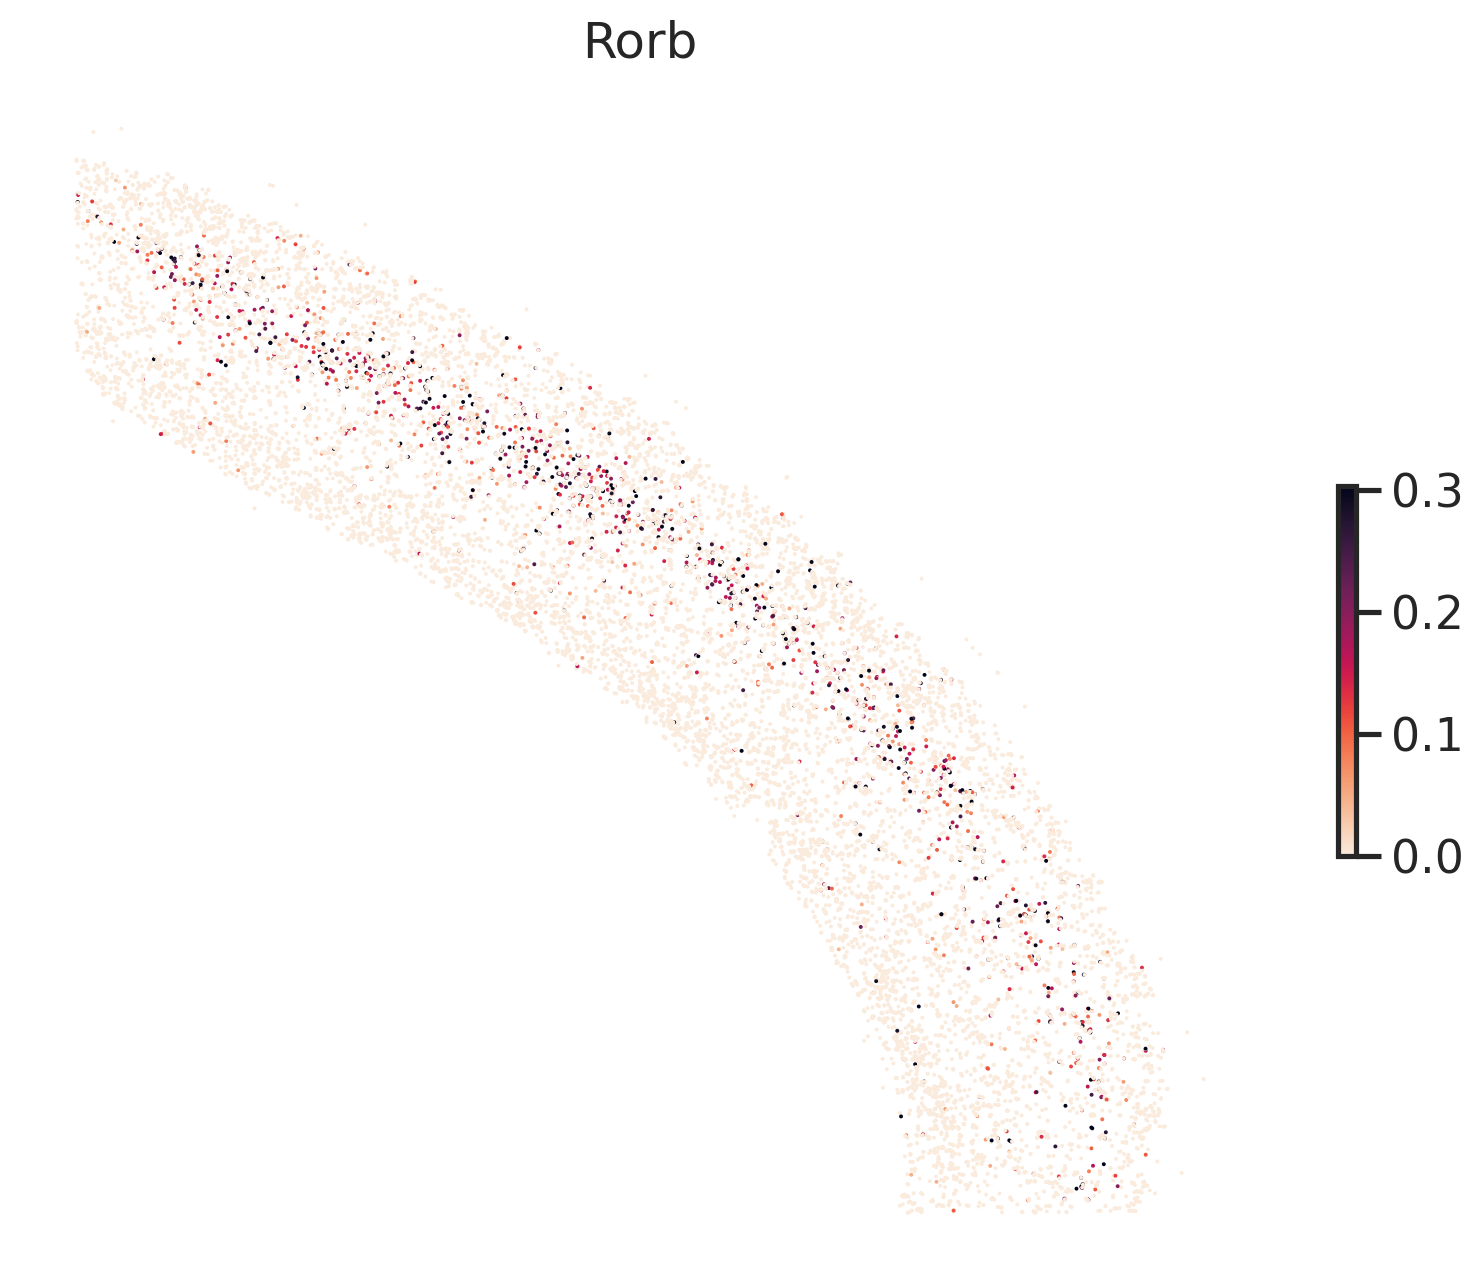

In [6]:
gn = 'Rorb'

x = adata.obs['x']
y = adata.obs['y']
ux = adata.obsm['umap'][:,0]
uy = adata.obsm['umap'][:,1]

g = np.log10(1+adata[:,gn].layers['norm'])
st_scatter(x, y, gexp=g, s=2, title=gn)



# st_scatter(x, y, gexp=g, s=2, title=gn, unit_norm=True)
# st_scatter(ux, uy, gexp=g, s=2, title=gn)

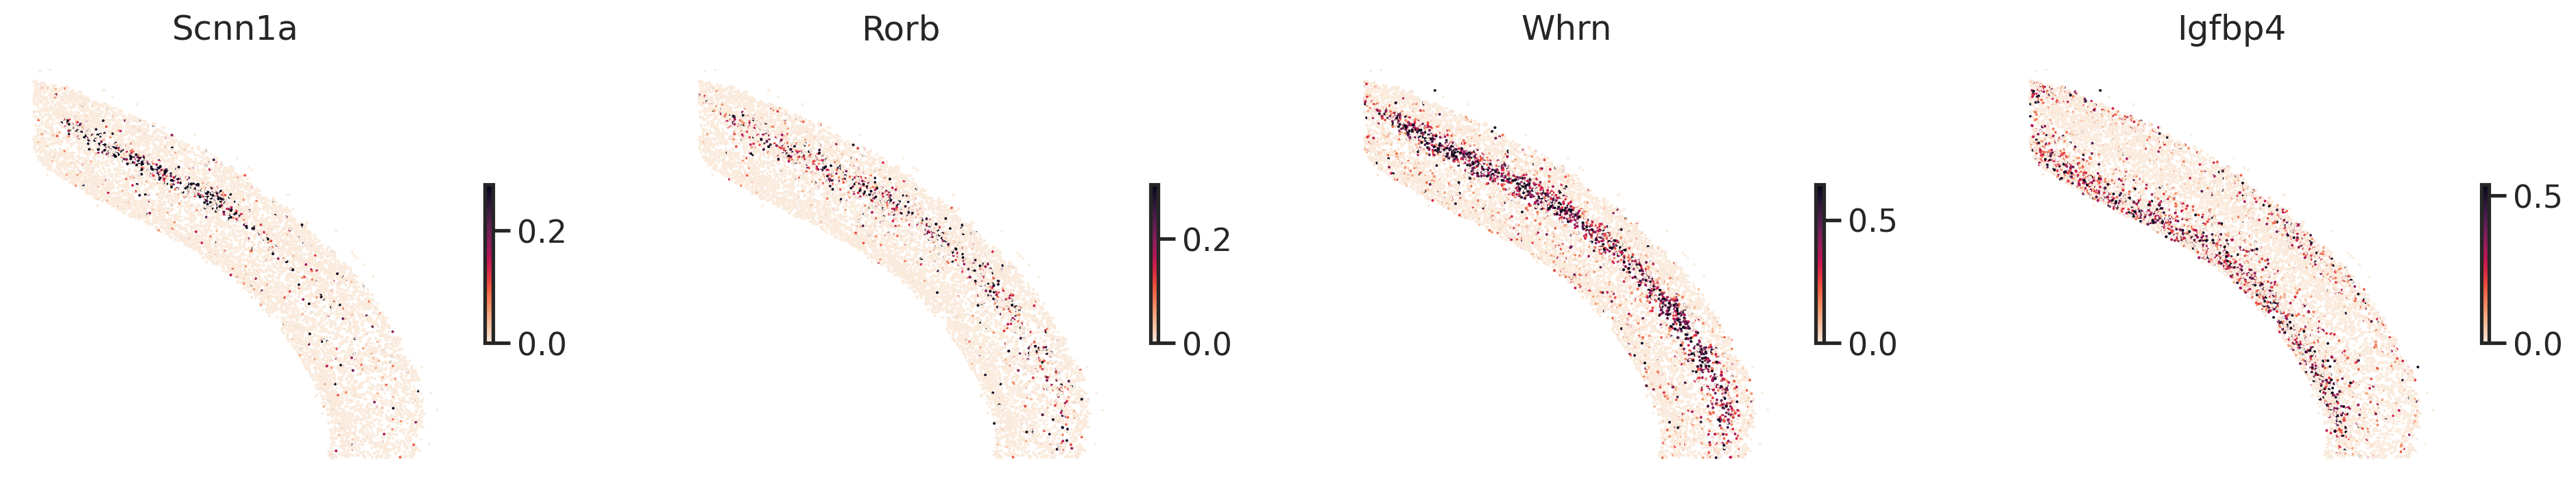

In [7]:

gns = ['Scnn1a', 'Rorb', 'Whrn', 'Igfbp4']
x = adata.obs['x']
y = adata.obs['y']
n = len(gns)

fig, axs = plt.subplots(1,n,figsize=(n*6,1*5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter_ax(ax, x, y, gexp=g, s=2, title=gn)
    
plt.show()

In [8]:
np.log10(1+2)

0.47712125471966244

In [9]:
# copy my code 

In [10]:
from scipy import spatial

def p_to_curve(query_point, pia_curve):
    """return the distance from a point to a set curve
    measure distance to each segment and take the min
    """
    tan_vec = pia_curve[1:] - pia_curve[:-1]
    # unit
    tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
    norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
    # np.power(tan_vec[:,0],2)+np.power(tan_vec[:,1],2) # check normed

    query_vec = (query_point - pia_curve[:-1])
    d = np.min(np.abs(query_vec[:,0]*norm_vec[:,0] + query_vec[:,1]*norm_vec[:,1]))
    return d

def ps_to_curve(query_points, pia_curve):
    """return the distance from a set of points to a set curve
    """
    tan_vec = pia_curve[1:] - pia_curve[:-1]
    # unit
    tan_vec = tan_vec/np.linalg.norm(tan_vec, axis=1).reshape(-1,1)
    norm_vec = tan_vec.dot(np.array([[0,-1],[1,0]]).T)
    
    query_mtx = np.repeat(XY[:,np.newaxis,:], len(pia_curve)-1, axis=1) - pia_curve[:-1]
    ds = np.min(np.abs(query_mtx[:,:,0]*norm_vec[:,0] + query_mtx[:,:,1]*norm_vec[:,1]), axis=1)
    return ds


In [11]:
class RefLineSegs:
    """
    """
    def __init__(self, ps):
        """
        line segments defined by ps
        """
        self.ps = ps
        self.rps = ps[:-1] # reference points (exclude the last point)
        self.ns = len(ps)-1 # number of segments
        # get ts and uts
        self.calc_tan_vec()
        
        return
    
    def calc_tan_vec(self):
        """get tangent vectors
        """
        ps = self.ps 
        ts = ps[1:] - ps[:-1]
        lts = np.linalg.norm(ts, axis=1)
        uts = ts/lts.reshape(-1,1)
        nuts = uts.dot(np.array([[0,-1],[1,0]]).T)
        
        # np.power(uts[:,0],2)+np.power(uts[:,1],2) # check normed
        
        self.ts = ts # tangents
        self.uts = uts # unitary tangents
        self.nuts = nuts # norm to unitary tangents
        
        self.lts = lts # tangent lengths
        self.cumlts = np.hstack([0,np.cumsum(lts)])[:-1] # cumulative tangent lengths
        
        return 
    
    def calc_seg_len(self):
        """get the length of each segment
        """
        ts = self.ts
        
        np.linalg.norm(ts, axis=1)
        
    
    
    def ndist_to_qp(self, query_point):
        """return the distance from a point to a set curve
        measure distance to each segment and take the min
        """
        query_vec = (query_point - self.rps)
        ndist = np.min(np.abs(query_vec[:,0]*self.nuts[:,0] + query_vec[:,1]*self.nuts[:,1]))
        
        return ndist
        
    def ndist_to_qps(self, XY):
        """return the distance from a point to a set curve
        measure distance to each segment and take the min
        """
        query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
        tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
        ndists = np.min(tmp, axis=1)
        
        return ndists
        
    def tdist_to_qps(self, XY):
        """return the distance from a point to a set curve
        adds up the distance of each segment
        """
        
        query_mtx = np.repeat(XY[:,np.newaxis,:], self.ns, axis=1) - self.rps
        tmp = np.abs(query_mtx[:,:,0]*self.nuts[:,0] + query_mtx[:,:,1]*self.nuts[:,1])
        
        # which segment
        min_seg_idx = np.argmin(tmp, axis=1)
        
        # cumsum up to the segment
        tdists = self.cumlts[min_seg_idx]
        
        
        uts = self.uts[min_seg_idx] # tangent vector for each ref point
        qs_vec = XY - self.rps[min_seg_idx] # 
        tdists_correction = qs_vec[:,0]*uts[:,0] + qs_vec[:,1]*uts[:,1]
        
        return tdists+tdists_correction
        


In [12]:
def binning(val, n):
    """
    """
    bins = np.linspace(np.min(val), np.max(val), n)
    binned = pd.cut(val, bins=bins)
    
    return bins, binned

In [13]:
meta = adata.obs.copy()

XY = meta[['x', 'y']].values

# convex hull
hull = spatial.ConvexHull(XY)
pia_vtx = hull.vertices[6:19][::-1] # reverse order
pia_curve = XY[pia_vtx]
pia_curve_obj = RefLineSegs(pia_curve)

# depth
meta['depth'] = pia_curve_obj.ndist_to_qps(XY)
meta['width'] = pia_curve_obj.tdist_to_qps(XY)

In [14]:
# bin it 

depth_bins, depth_binned = binning(meta['depth'].values, 20)
meta['depth_bin'] = depth_binned

width_bins, width_binned = binning(meta['width'].values, 20)
meta['width_bin'] = width_binned


Text(0.5, 1.0, 'P28 anterior')

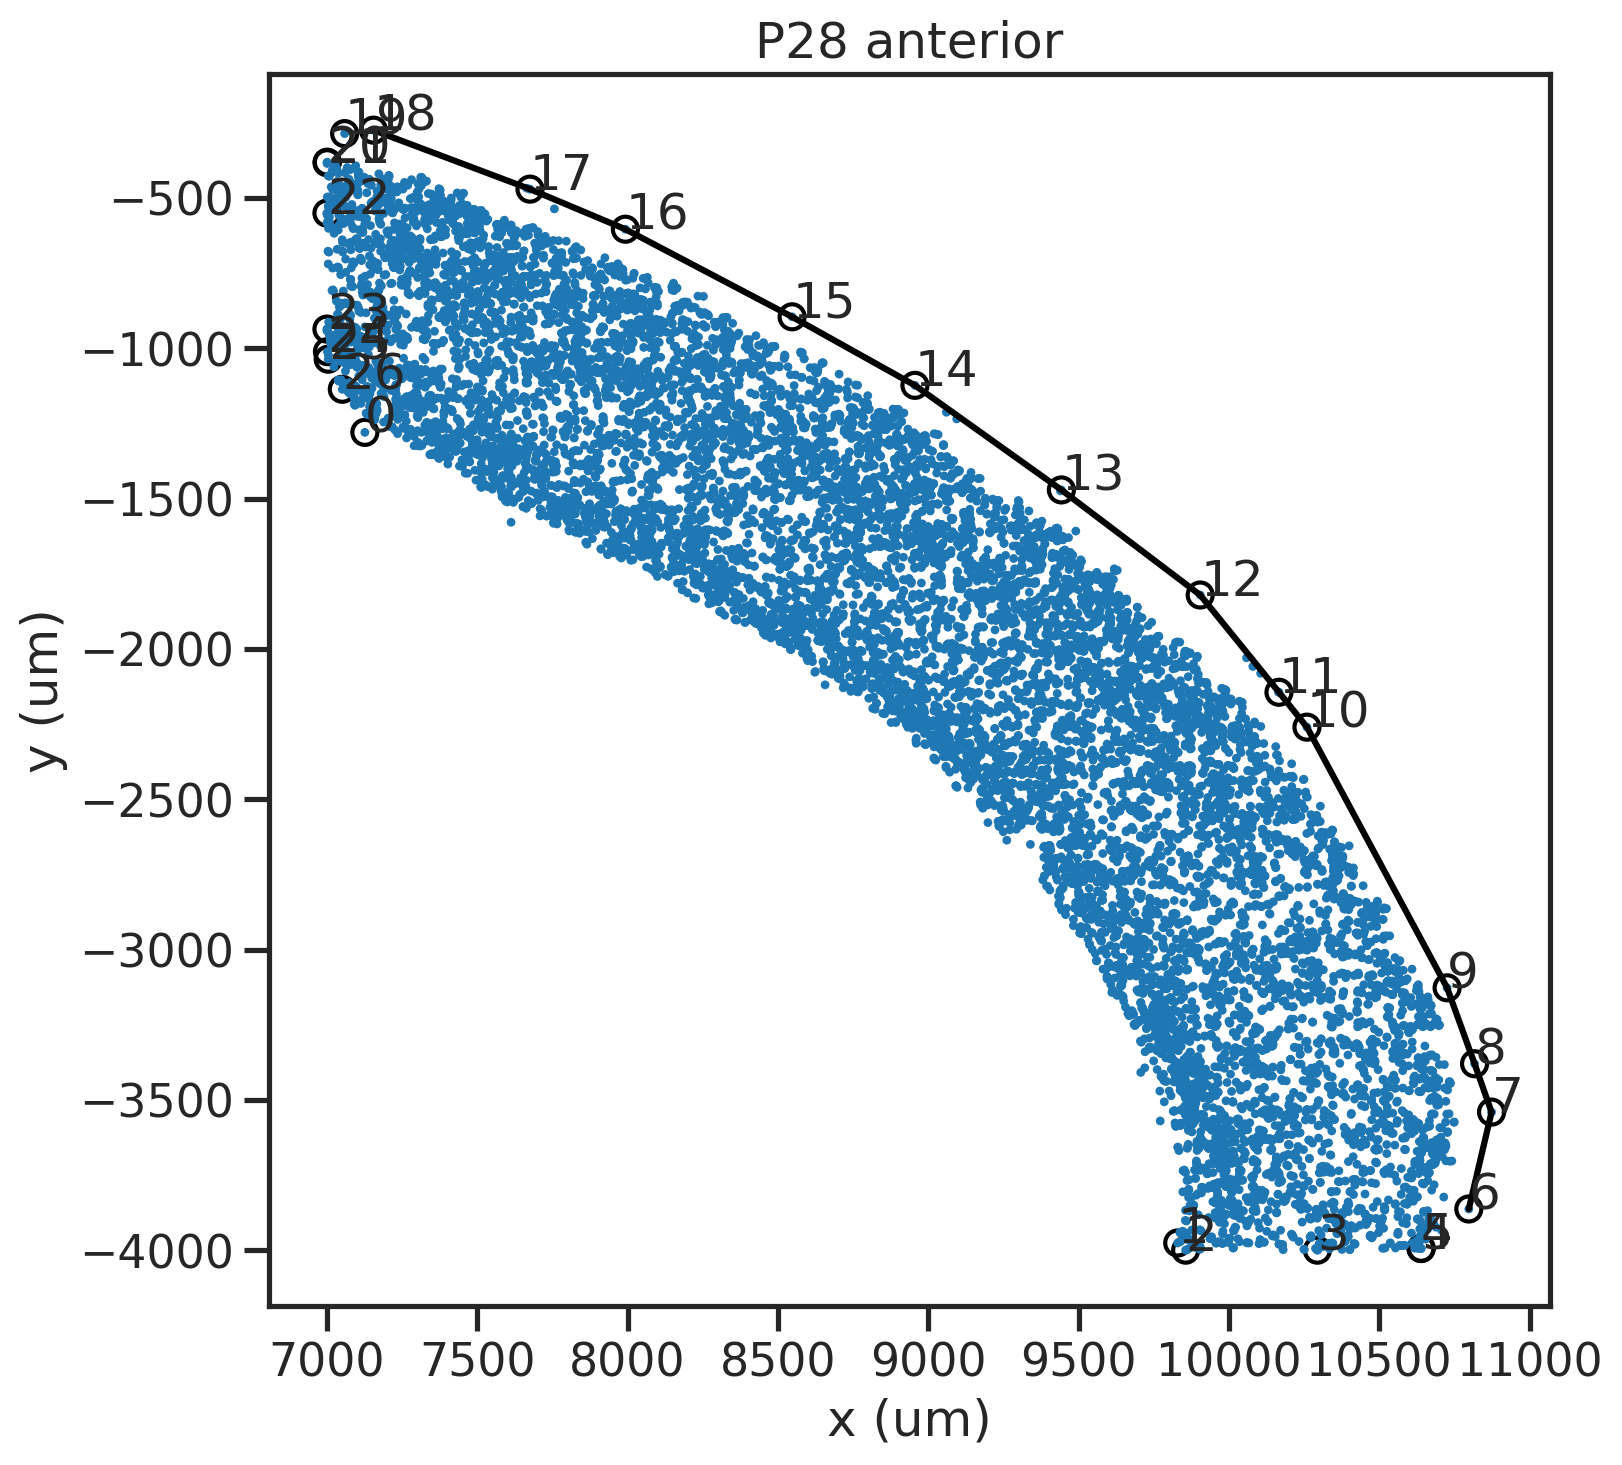

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
for i, vtx in enumerate(hull.vertices):
    ax.scatter(XY[vtx, 0], XY[vtx, 1], facecolors='none', edgecolors='k')
    ax.text(XY[vtx, 0], XY[vtx, 1], i)
    
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-k')
    
sns.scatterplot(data=meta, x='x', y='y', 
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'P28 anterior')

Text(0.5, 1.0, 'width')

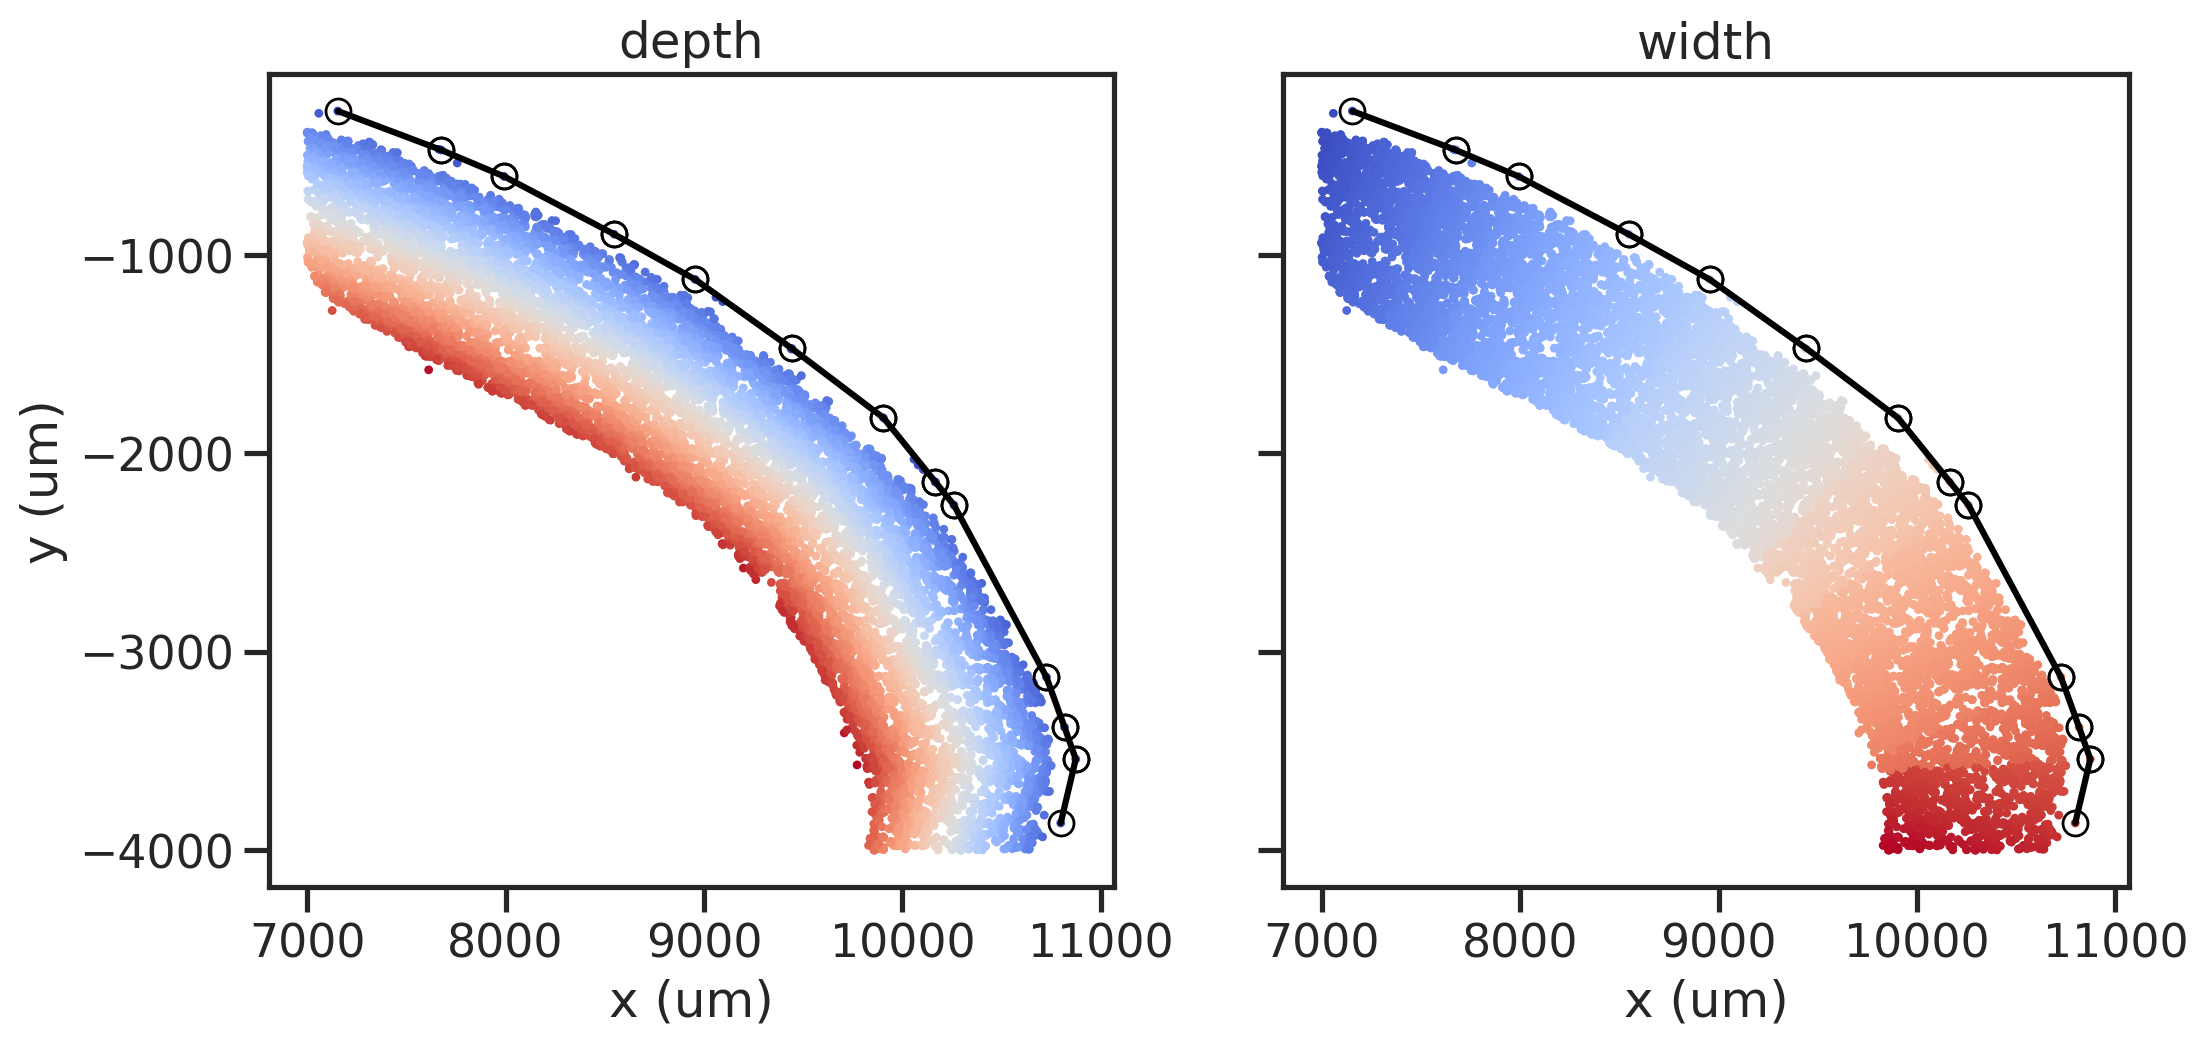

In [16]:
fig, axs = plt.subplots(1,2,figsize=(12,8*2), sharex=True, sharey=True)
ax = axs[0]
    
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-ok', fillstyle='none')
    
sns.scatterplot(data=meta, x='x', y='y', 
                hue='depth', 
                palette='coolwarm',
                legend=False,
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'depth')

ax = axs[1]
for i in range(len(pia_curve)-1):
    ax.plot(pia_curve[i:i+2, 0], 
            pia_curve[i:i+2, 1], 
            '-ok', fillstyle='none')
    
sns.scatterplot(data=meta, x='x', y='y', 
                hue='width', 
                palette='coolwarm',
                legend=False,
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('x (um)')
ax.set_ylabel('y (um)')
ax.set_title(f'width')

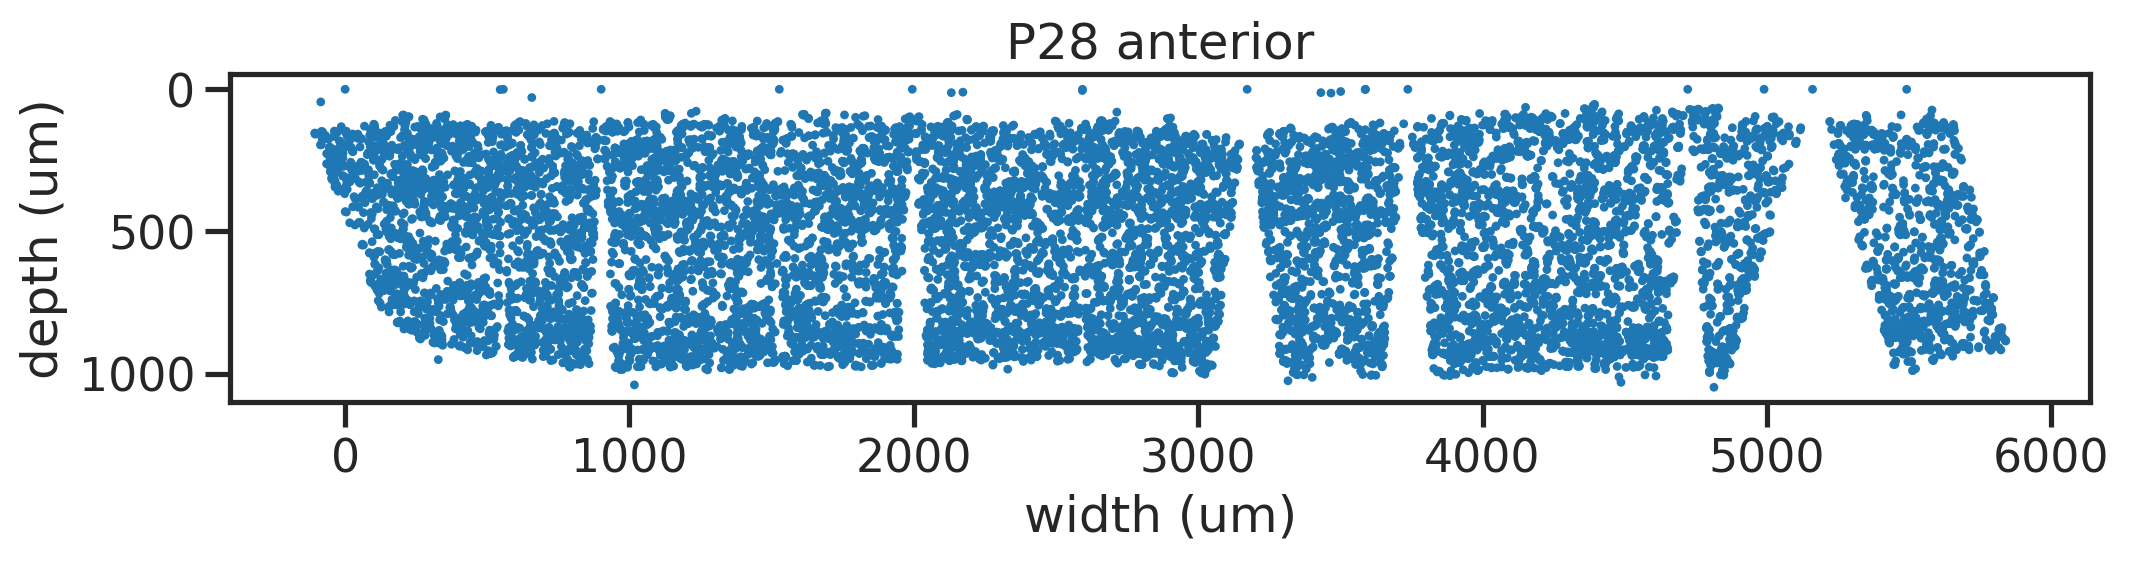

In [17]:
fig, ax = plt.subplots(1,1,figsize=(12,4*1))
sns.scatterplot(data=meta, x='width', y='depth', 
                # hue='width', 
                # palette='coolwarm',
                s=10, edgecolor='none', ax=ax)
ax.grid(False)
ax.set_aspect('equal')
ax.set_xlabel('width (um)')
ax.set_ylabel('depth (um)')
ax.set_title(f'P28 anterior')
ax.invert_yaxis()
# ax.legend(bbox_to_anchor=(1,1))

In [18]:
adata.obs

x            y  gncov  fpcov             EntityID   fov  \
255753   7058.968676  -286.195793     26      0  2596588902602100141  2108   
255803   7001.412688  -497.028420    338      4  2596588902603100039  2107   
255806   7006.998890  -426.458808    105      0  2596588902603100043  2107   
255811   7014.474548  -463.583874     40      2  2596588902603100049  2107   
255812   7018.950874  -471.339315    276      3  2596588902603100050  2107   
...              ...          ...    ...    ...                  ...   ...   
373870  10734.473917 -3704.235356     95      2  2596588904136100156  2475   
373894  10797.962283 -3862.932954     11      0  2596588904137100026  2474   
373917  10714.698378 -3823.258623     11      0  2596588904137100065  2475   
374010  10706.653006 -3932.947219     14      0  2596588904138100061  2474   
374773  10873.632775 -3540.763117     11      0  2596588904187100094  2483   

             volume     center_x      center_y        min_x  ...  \
255753   322.497815   286.195793   7058.968676   281.162506  ...   
255803  1006.200478   497.028420   7001.412688   489.837728  ...   
255806   170.863766   426.458808   7006.998890   421.980624  ...   
255811   160.282140   463.583874   7014.474548   460.360619  ...   
255812   734.174348   471.339315   7018.950874   466.412759  ...   
...             ...          ...           ...          ...  ...   
373870   315.201245  3704.235356  10734.473917  3686.777710  ...   
373894    44.628028  3862.932954  10797.962283  3858.829838  ...   
373917   136.121122  3823.258623  10714.698378  3810.805930  ...   
374010   187.536860  3932.947219  10706.653006  3920.655203  ...   
374773    54.181630  3540.763117  10873.632775  3536.118464  ...   

        perimeter_area_ratio  solidity     DAPI_raw  DAPI_high_pass  \
255753              0.797568  0.900716   49535118.0    5.170313e+05   
255803              0.442104  5.357435  335137907.0    3.227093e+06   
255806              0.560939  1.358082   51604431.0    5.563088e+05   
255811              0.732205  3.782825  167889286.0    3.483219e+06   
255812              0.533842  5.055467  302597165.0    3.828594e+06   
...                      ...       ...          ...             ...   
373870              0.679770  0.547051   13521868.0    1.913689e+05   
373894              1.340398  0.484072    2138863.0    2.474137e+04   
373917              0.855484  0.444151    8199267.0    1.553553e+05   
374010              0.544417  0.320200    5566136.0    6.591432e+04   
374773              0.806993  0.747767   19366539.0    3.359073e+05   

           PolyT_raw  PolyT_high_pass  leiden_r0.1  leiden_r0.2  \
255753  4.586120e+07     3.343286e+05            0            0   
255803  2.490582e+09     3.808631e+06            0            0   
255806  2.192814e+08     9.114385e+06            0            0   
255811  4.073465e+08     3.531748e+05            0            0   
255812  1.750066e+09     5.396450e+06            0            0   
...              ...              ...          ...          ...   
373870  4.708399e+07     4.117300e+05            0            0   
373894  5.664845e+06     4.346864e+04            0            0   
373917  1.891155e+07     5.660286e+05            0            0   
374010  3.618883e+07     6.265085e+05            0            0   
374773  9.703853e+06     1.125121e+05            0            0   

        leiden_spatial_r0.02  leiden_r0.5  
255753                     0            1  
255803                     0            1  
255806                     0            2  
255811                     0            2  
255812                     0            2  
...                      ...          ...  
373870                     1            2  
373894                     1            2  
373917                     1            1  
374010                     1            4  
374773                     1            3  

[15669 rows x 25 columns]

In [19]:
adata.obs['depth'] = meta['depth']
adata.obs['width'] = meta['width']

/tmp/ipykernel_50023/2461476148.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['depth'] = meta['depth']


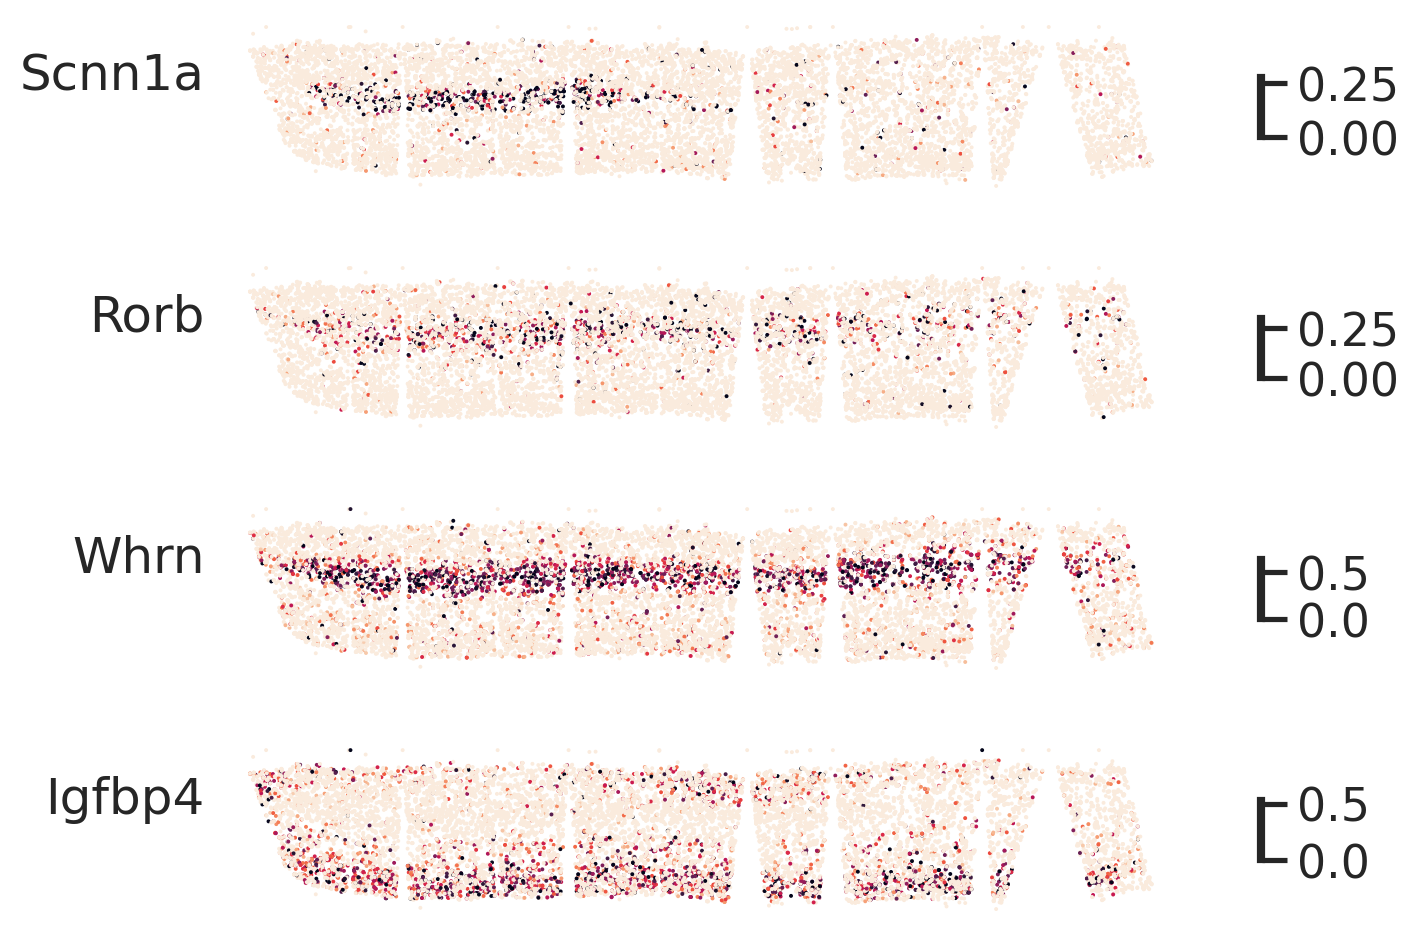

In [20]:


gns = ['Scnn1a', 'Rorb', 'Whrn', 'Igfbp4']
x = adata.obs['width']
y = -adata.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*8,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adata[:,gn].layers['norm'])
    st_scatter_ax(ax, x, y, gexp=g, s=2, title="")
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    
plt.show()

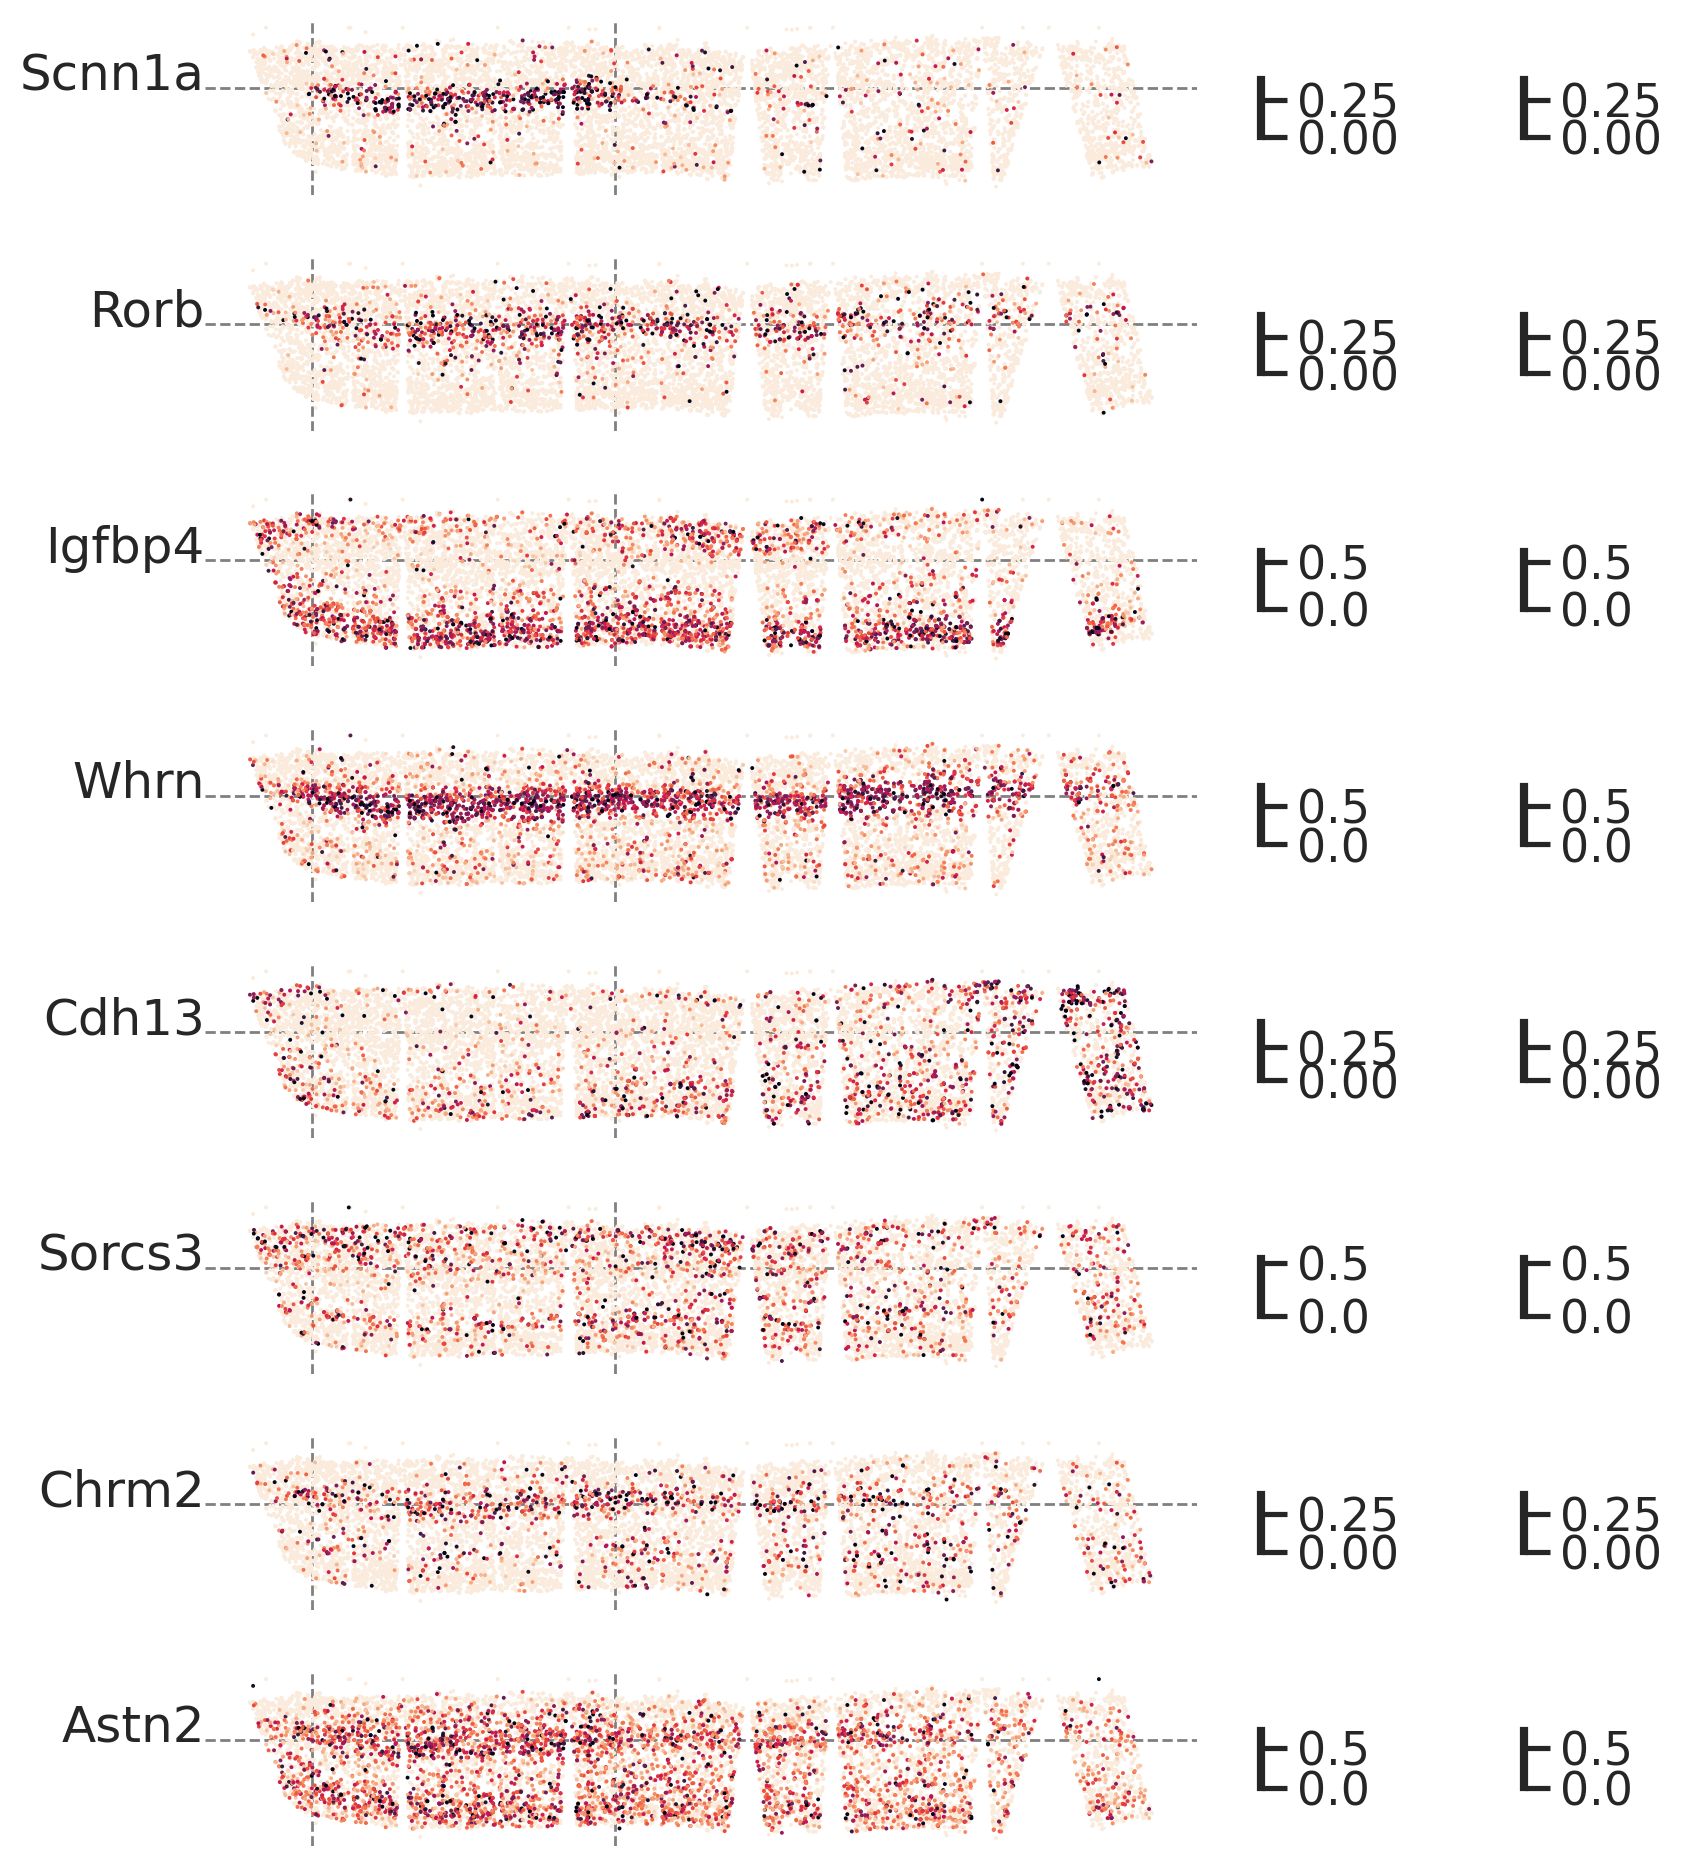

In [21]:
gns = ['Scnn1a', 'Rorb', 'Igfbp4', 'Whrn', 'Cdh13', 'Sorcs3', 'Chrm2', 'Astn2']
x = adata.obs['width']
y = -adata.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*10,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adata[:,gn].layers['norm']).reshape(-1,)
    
    vmax = np.percentile(g, 99)
    vmin = np.percentile(g,  5)
    cond = g > 1e-5
    
    utils_merfish.st_scatter_ax(fig, ax, x[~cond], y[~cond], gexp=g[~cond], s=2, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    utils_merfish.st_scatter_ax(fig, ax,  x[cond],  y[cond],  gexp=g[cond], s=2, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    ax.axhline(-400, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( 300, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline(2300, linestyle='--', linewidth=1, color='gray', zorder=0)
    # ax.grid(True)
    # ax.axis('on')
    
plt.show()

In [22]:
cond_v1l23 = np.all([
    adata.obs['width'] > 300,
    adata.obs['width'] < 2300,
    adata.obs['depth'] < 400,
], axis=0)

adatasub = adata[cond_v1l23]
adata, adatasub

(AnnData object with n_obs × n_vars = 15669 × 500
     obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'leiden_r0.2', 'leiden_spatial_r0.02', 'leiden_r0.5', 'depth', 'width'
     uns: 'leiden', 'neighbors'
     obsm: 'blanks', 'pca', 'umap', 'xy'
     layers: 'norm'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 2193 × 500
     obs: 'x', 'y', 'gncov', 'fpcov', 'EntityID', 'fov', 'volume', 'center_x', 'center_y', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'DAPI_raw', 'DAPI_high_pass', 'PolyT_raw', 'PolyT_high_pass', 'leiden_r0.1', 'leiden_r0.2', 'leiden_spatial_r0.02', 'leiden_r0.5', 'depth', 'width'
     uns: 'leiden', 'neighbors'
     obsm: 'blanks', 'pca', 'umap', 

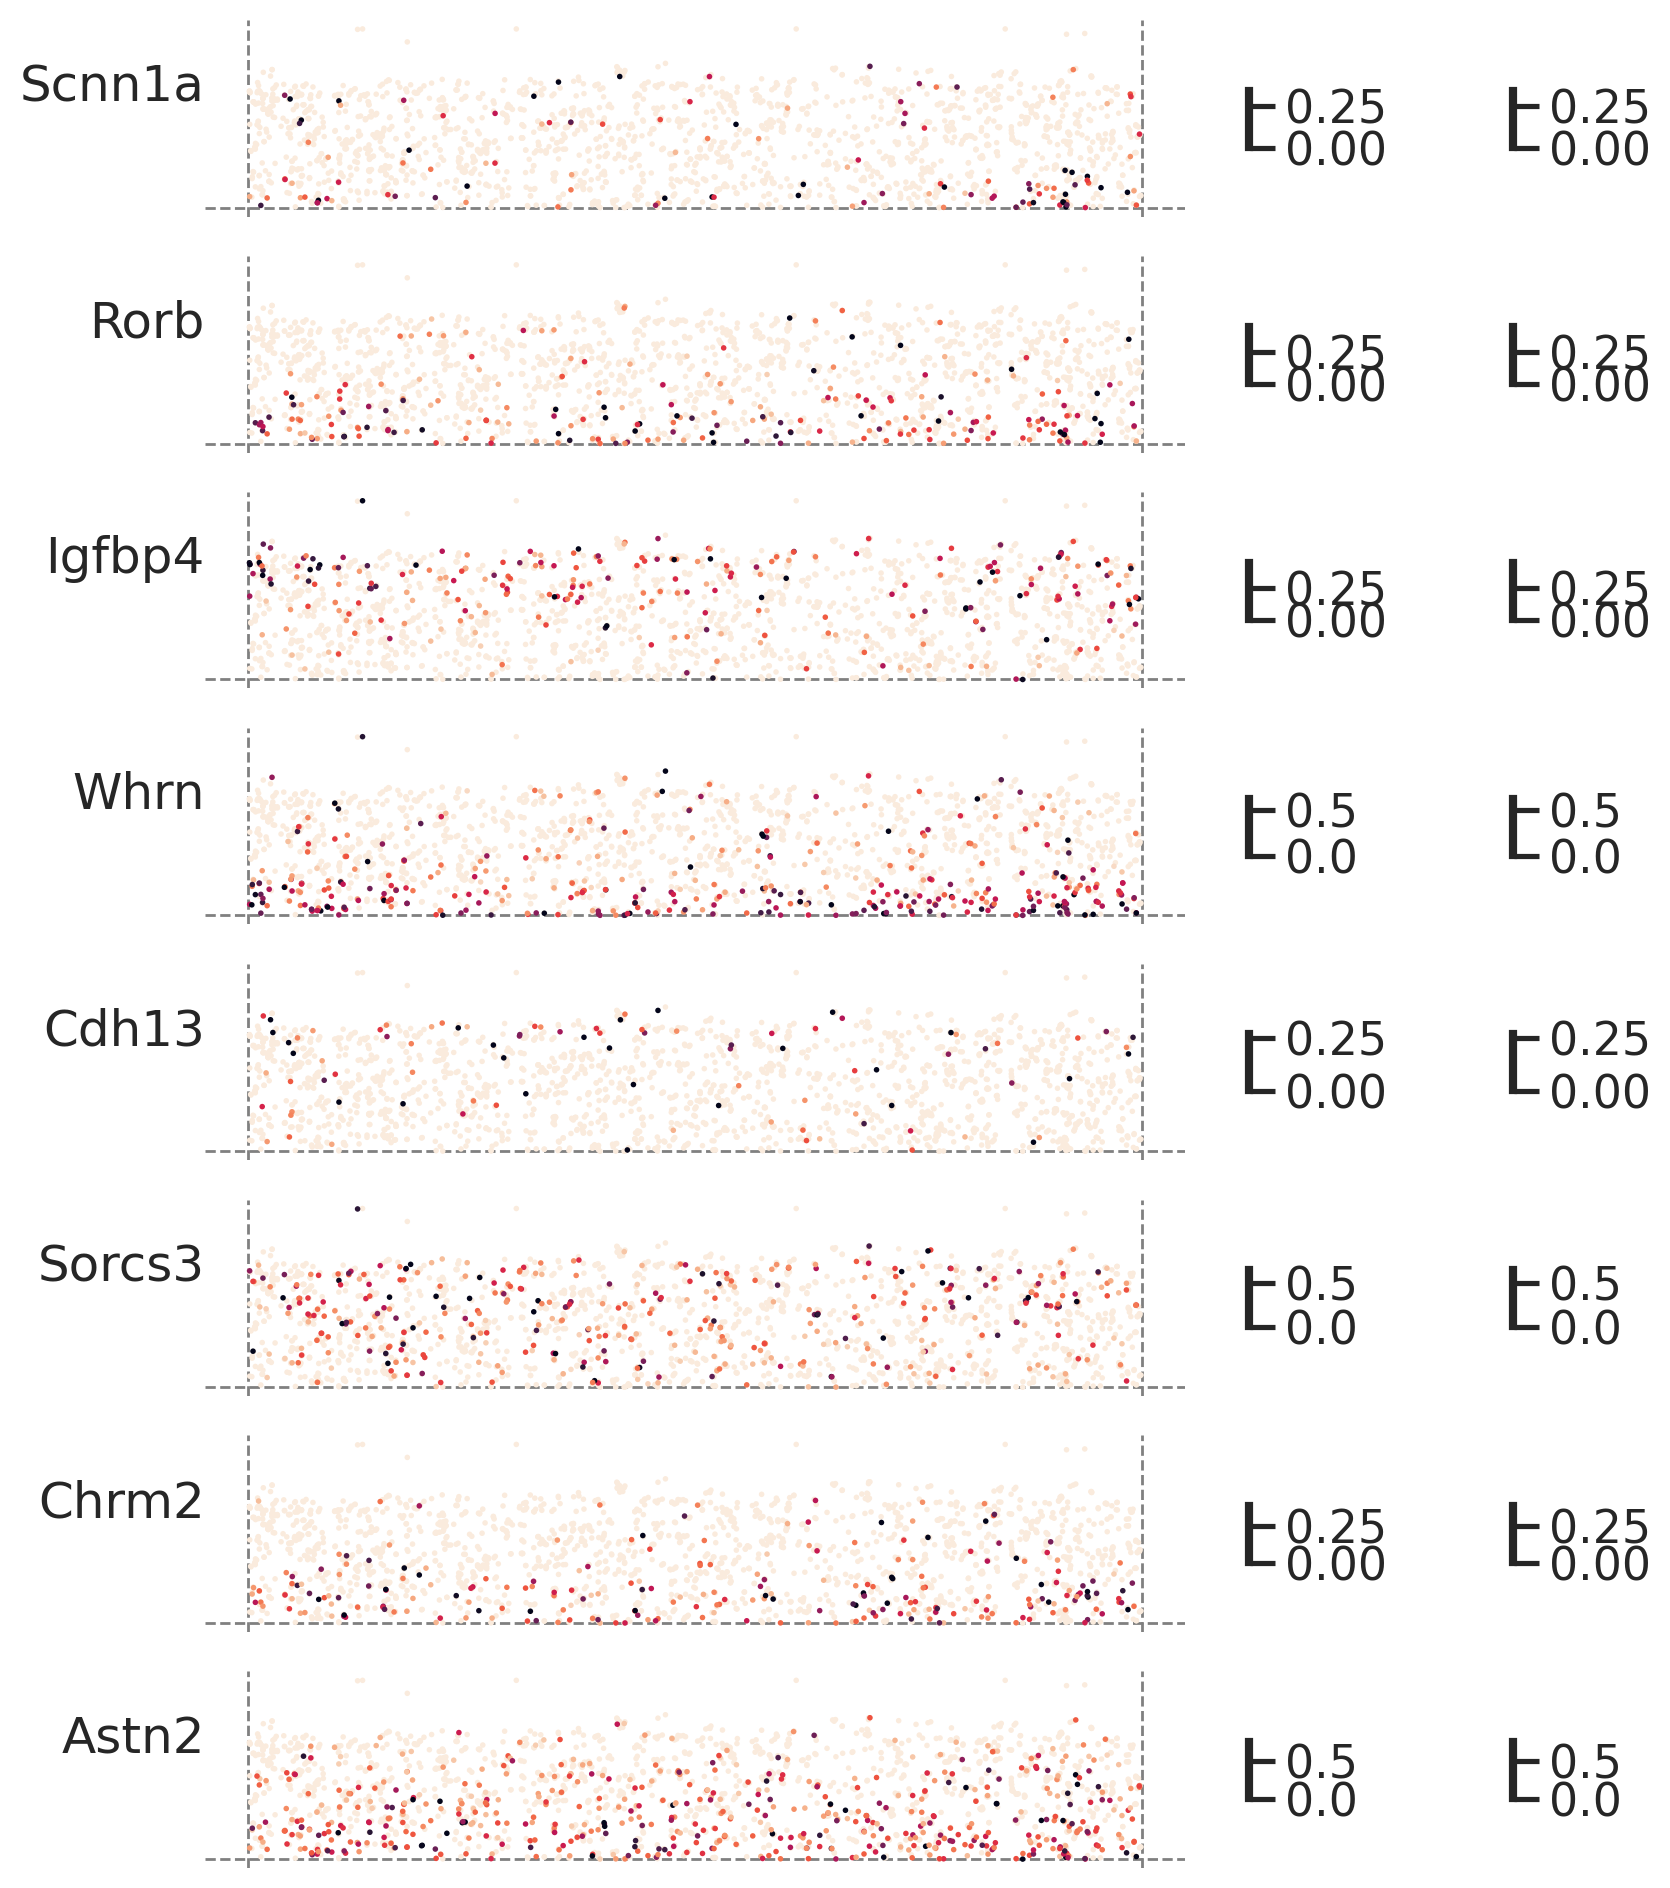

In [23]:
# gns = ['Scnn1a', 'Rorb', 'Igfbp4', 'Whrn', 'Cdh13', 'Sorcs3', 'Chrm2']
x = adatasub.obs['width']
y = -adatasub.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*10,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adatasub[:,gn].layers['norm']).reshape(-1,)
    
    vmax = np.percentile(g, 99)
    vmin = np.percentile(g,  5)
    cond = g > 1e-5
    
    utils_merfish.st_scatter_ax(fig, ax, x[~cond], y[~cond], gexp=g[~cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    utils_merfish.st_scatter_ax(fig, ax,  x[cond],  y[cond],  gexp=g[cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    ax.axhline(-400, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( 300, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline(2300, linestyle='--', linewidth=1, color='gray', zorder=0)
    # ax.grid(True)
    # ax.axis('on')
    
plt.show()

In [24]:
# adata.write('/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results_merfish/pos_reg1_ctxglut_230922.h5ad')

# ABC genes

In [66]:
def binning_pipe(adata, n=20, layer='lnorm', bin_type='depth_bin'):
    """
    """
    assert bin_type in ['depth_bin', 'width_bin']
    # bin it 
    depth_bins, depth_binned = utils_merfish.binning(adata.obs['depth'].values, n)
    width_bins, width_binned = utils_merfish.binning(adata.obs['width'].values, n)

    norm_ = pd.DataFrame(adata.layers[layer], columns=adata.var.index)
    norm_['depth_bin'] = depth_binned
    norm_['width_bin'] = width_binned
    
    norm_mean = norm_.groupby(bin_type).mean()
    norm_sem  = norm_.groupby(bin_type).sem()
    norm_std  = norm_.groupby(bin_type).std()
    norm_n    = norm_[bin_type].value_counts(sort=False)

    return norm_mean, norm_sem, norm_std, norm_n, depth_binned, width_binned, depth_bins, width_bins

In [26]:
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/MERFISH_gene_panel_Version1_March9.csv'
df1 = pd.read_csv(f)
f = '/u/home/f/f7xiesnm/project-zipursky/v1-bb/v1/results/gene_ptime_P28_L23_Mar27.tsv'
df2 = pd.read_csv(f).sort_values('gene_ptime')
df = pd.merge(df1, df2, left_on='gene_name_data', right_on='gene').sort_values('gene_ptime')
genes_abco = df['gene_name_vizgen'].values
genes_abco.shape

(170,)

In [27]:
agenes = df[df['P17on_x']=='A']['gene_name_vizgen'].values
bgenes = df[df['P17on_x']=='B']['gene_name_vizgen'].values
cgenes = df[df['P17on_x']=='C']['gene_name_vizgen'].values
len(agenes), agenes, len(bgenes), bgenes, len(cgenes), cgenes

(64,
 array(['Met', '6530403H02Rik', 'Rhbdl3', 'Adamts2', 'Cdh13', 'Col23a1',
        'Vwc2l', 'Syt10', 'Kcnn3', 'Arhgef28', 'Pcdh19', 'Pakap', 'Ikzf2',
        'Nckap5', 'Dpyd', 'Gpc5', 'Slc6a7', 'Igsf11', 'Glis3', 'Ttc28',
        'Tenm1', 'Syt17', 'Robo1', 'Sema6a', 'Otof', 'Eda', 'Plxna1',
        'Tox3', 'Itga8', 'Kcnk13', 'Wnt4', 'Sdk2', 'Pdzrn4', 'Plxnd1',
        'Ryr3', 'Necab1', 'Camk2d', 'Iqgap2', 'Pdgfc', 'Gabrg3', 'Dscaml1',
        'Reln', 'Npas3', 'Cntn5', 'Rfx3', 'Grm1', 'Kirrel3', 'Nfib',
        'Fkbp5', 'Zfp608', 'Meis2', 'Mdga1', 'Tiam1', 'Grb14', 'Nkain3',
        'Epha6', 'Cacna1h', 'Pde1a', 'Nr3c2', 'Matn2', 'Tmem150c',
        'Adamts17', 'Ldb2', 'Egfem1'], dtype=object),
 35,
 array(['Grm8', 'Galnt17', 'Epha3', 'Rgs8', 'Sox5', 'Zfp804b', 'Tmeff1',
        'Fstl5', 'Cdh4', 'Kcnip3', 'Myh9', 'Sh3pxd2b', 'Klhl1', 'Trpc6',
        'Sema4a', 'Tafa1', 'Sertm1', 'Nrp1', 'Col26a1', 'Mas1', 'Igfn1',
        'Npas4', 'Scg3', 'Nptx2', 'Bdnf', 'Phf21b', 'Nell1', 'Baz1a',
 

In [29]:
agenes_idx = basicu.get_index_from_array(adatasub.var.index.values, agenes)
bgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, bgenes)
cgenes_idx = basicu.get_index_from_array(adatasub.var.index.values, cgenes)

In [32]:
adatasub.layers['lnorm'] = np.log10(1+adatasub.layers['norm']) # .sum(axis=1)

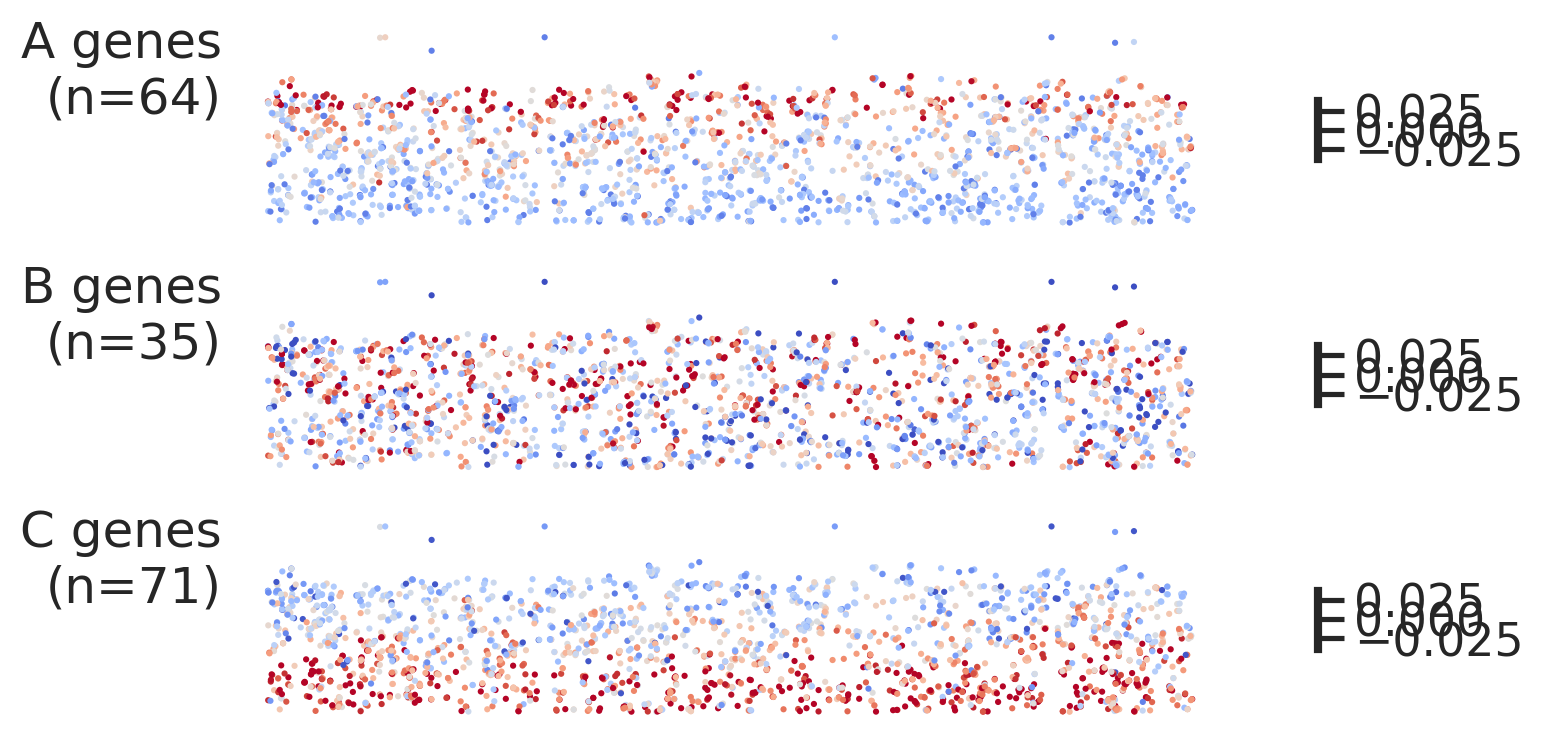

In [46]:
depth = adatasub.obs['depth'].values
width = adatasub.obs['width'].values
mat   = adatasub.layers['lnorm']

# x, y, _ = utils_merfish.get_xyg(adata, 'Cdh13', 'norm')
# xr, yr = rot2d(x, y, theta)
                                
fig, axs = plt.subplots(3,1,figsize=(10,3*1.5))
gnames = ['A genes\n(n=64)', 'B genes\n(n=35)', 'C genes\n(n=71)']
for i, (_idx, _baseline) in enumerate(zip([agenes_idx, bgenes_idx, cgenes_idx], 
                                        [am, bm, cm])):
    ax = axs[i]
    lnorm_ = mat[:,_idx].copy()
    g = (lnorm_ - np.array(_baseline).reshape(1,-1)).mean(axis=1) 
    gn = gnames[i]
    vmax = +0.04 # np.percentile(g, 95)
    vmin = -0.04 # np.percentile(g,  0)
    
    utils_merfish.st_scatter_ax(fig, ax, width, -depth, gexp=g, s=5, title='', vmin=vmin, vmax=vmax, cmap='coolwarm') #, axis_off=False)
    ax.set_title(gn, loc='left', ha='right', y=0.5)
plt.show()

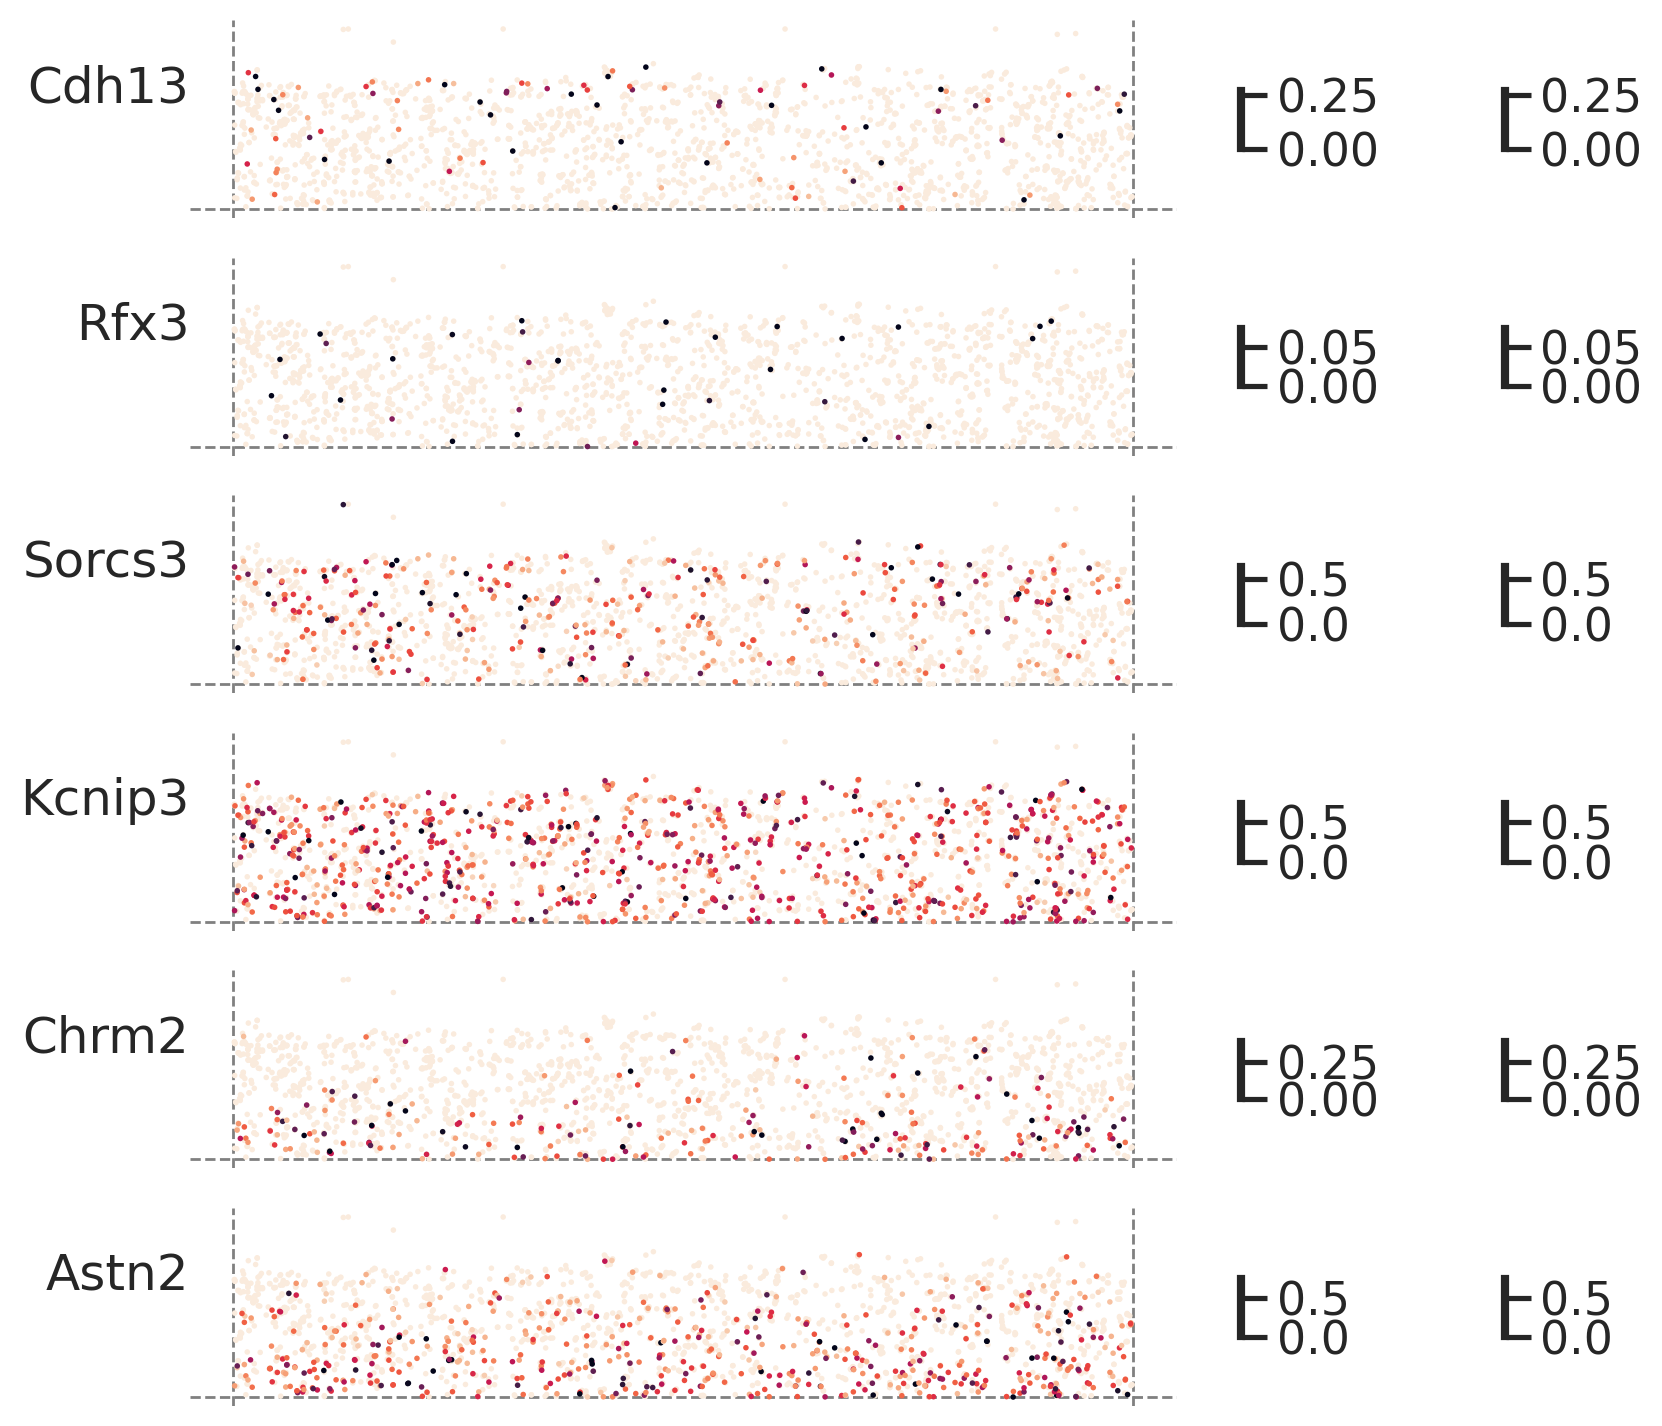

In [52]:
gns = ['Cdh13', 'Rfx3', 'Sorcs3', 'Kcnip3', 'Chrm2', 'Astn2']
x = adatasub.obs['width']
y = -adatasub.obs['depth']
n = len(gns)

fig, axs = plt.subplots(n,1,figsize=(1*10,n*1.5))
for ax, gn in zip(axs, gns):
    # gn = 'Scnn1a'
    g = np.log10(1+adatasub[:,gn].layers['norm']).reshape(-1,)
    
    vmax = np.percentile(g, 99)
    vmin = np.percentile(g,  5)
    cond = g > 1e-5
    
    utils_merfish.st_scatter_ax(fig, ax, x[~cond], y[~cond], gexp=g[~cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    utils_merfish.st_scatter_ax(fig, ax,  x[cond],  y[cond],  gexp=g[cond], s=4, title='', vmin=vmin, vmax=vmax, cmap='rocket_r') #, axis_off=False)
    
    ax.set_title(gn, loc='left', ha='right', y=0.5)
    ax.axhline(-400, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline( 300, linestyle='--', linewidth=1, color='gray', zorder=0)
    ax.axvline(2300, linestyle='--', linewidth=1, color='gray', zorder=0)
    # ax.grid(True)
    # ax.axis('on')
    
plt.show()

# stats

In [72]:
lnorm_mean, lnorm_sem, lnorm_std, n, d, w, db, wb = binning_pipe(adatasub, n=10)
d.value_counts()

/tmp/ipykernel_50023/773494810.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_mean = norm_.groupby(bin_type).mean()
/tmp/ipykernel_50023/773494810.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_sem  = norm_.groupby(bin_type).sem()
/tmp/ipykernel_50023/773494810.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_std  = norm_.groupby(bin_type).std()


(0.0, 44.443]           4
(44.443, 88.887]       11
(88.887, 133.33]      162
(133.33, 177.774]     341
(177.774, 222.217]    344
(222.217, 266.66]     326
(266.66, 311.104]     317
(311.104, 355.547]    350
(355.547, 399.991]    334
dtype: int64

In [73]:
tmp = lnorm_mean.iloc[:,agenes_idx].copy()
am = np.mean(tmp, axis=0) # across depth bins
amean = (tmp - am).mean(axis=1) # across genes

tmp = lnorm_mean.iloc[:,bgenes_idx].copy()
bm = np.mean(tmp, axis=0)
bmean = (tmp - bm).mean(axis=1)

tmp = lnorm_mean.iloc[:,cgenes_idx].copy()
cm = np.mean(tmp, axis=0)
cmean = (tmp - cm).mean(axis=1)

# sem
tmp2 = lnorm_sem.iloc[:,agenes_idx].copy()
asem = tmp2.mean(axis=1)

tmp2 = lnorm_sem.iloc[:,bgenes_idx].copy()
bsem = tmp2.mean(axis=1)

tmp2 = lnorm_sem.iloc[:,cgenes_idx].copy()
csem = tmp2.mean(axis=1)

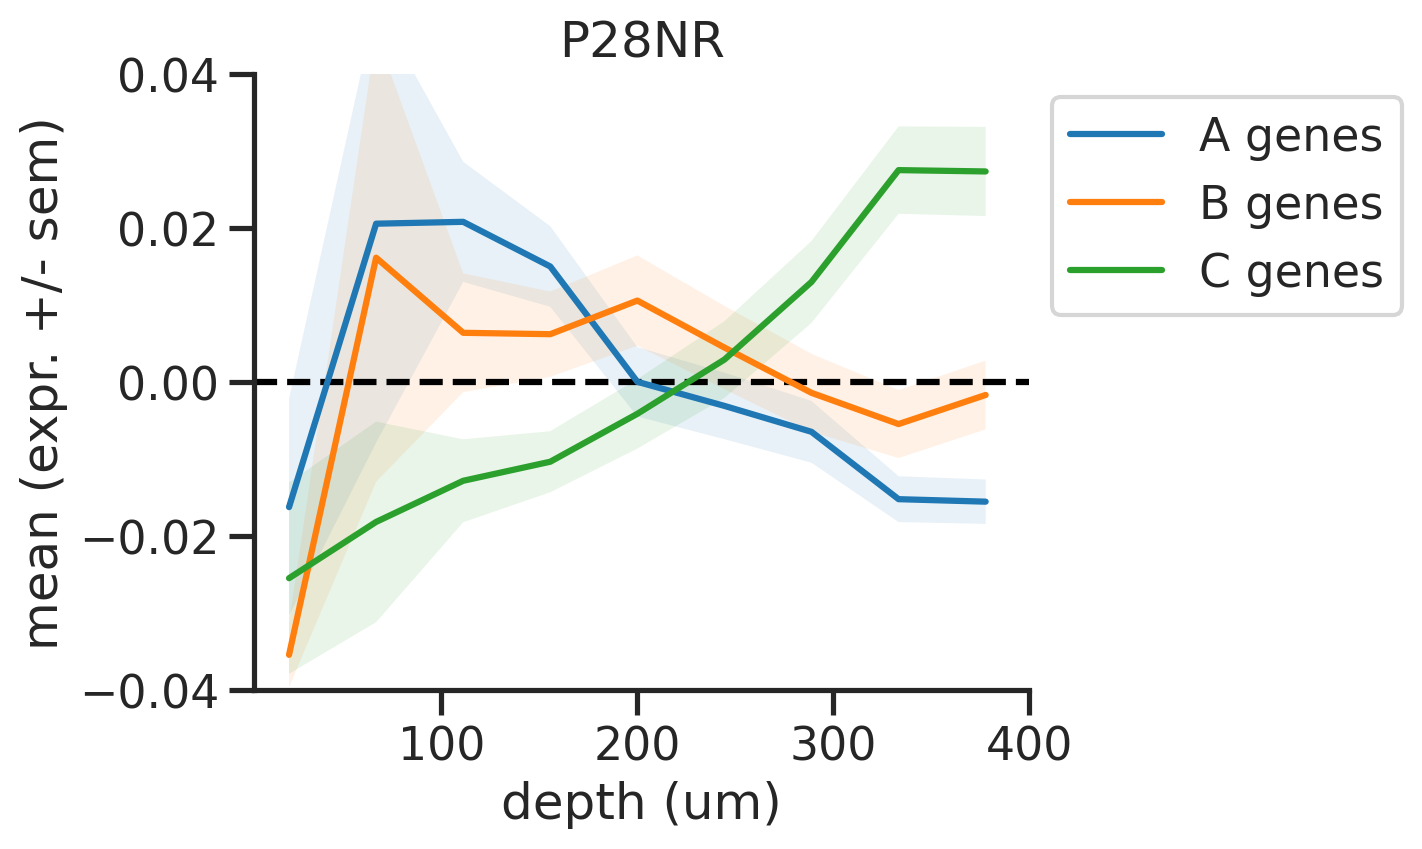

In [74]:
gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
x = np.mean(np.vstack([db[:-1], db[1:]]), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5*1,4), sharex=True, sharey=True)

ax.plot(x, amean, label='A genes', color='C0', linestyle='-')
ax.fill_between(x, amean-asem, amean+asem, color='C0', alpha=0.1, edgecolor='none')
ax.plot(x, bmean, label='B genes', color='C1', linestyle='-')
ax.fill_between(x, bmean-bsem, bmean+bsem, color='C1', alpha=0.1, edgecolor='none')
ax.plot(x, cmean, label='C genes', color='C2', linestyle='-')
ax.fill_between(x, cmean-csem, cmean+csem, color='C2', alpha=0.1, edgecolor='none')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('P28NR')
ax.set_xlabel('depth (um)')


ax.set_ylim([-0.04, 0.04])
ax.grid(False)
    
ax.set_xlim(xmax=400)
ax.set_ylabel('mean (expr. +/- sem)')
fig.subplots_adjust(wspace=0.1)
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq_abc_v3.pdf')

# stats width

In [81]:
lnorm_mean, lnorm_sem, lnorm_std, n, d, w, db, wb = binning_pipe(adatasub, n=10, bin_type='width_bin')
w.value_counts()

/tmp/ipykernel_50023/773494810.py:13: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_mean = norm_.groupby(bin_type).mean()
/tmp/ipykernel_50023/773494810.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_sem  = norm_.groupby(bin_type).sem()
/tmp/ipykernel_50023/773494810.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  norm_std  = norm_.groupby(bin_type).std()


(303.208, 524.892]      300
(524.892, 746.575]      263
(746.575, 968.259]      208
(968.259, 1189.942]     259
(1189.942, 1411.626]    222
(1411.626, 1633.309]    195
(1633.309, 1854.992]    224
(1854.992, 2076.676]    241
(2076.676, 2298.359]    280
dtype: int64

In [76]:
tmp = lnorm_mean.iloc[:,agenes_idx].copy()
am = np.mean(tmp, axis=0) # across depth bins
amean = (tmp - am).mean(axis=1) # across genes

tmp = lnorm_mean.iloc[:,bgenes_idx].copy()
bm = np.mean(tmp, axis=0)
bmean = (tmp - bm).mean(axis=1)

tmp = lnorm_mean.iloc[:,cgenes_idx].copy()
cm = np.mean(tmp, axis=0)
cmean = (tmp - cm).mean(axis=1)

# sem
tmp2 = lnorm_sem.iloc[:,agenes_idx].copy()
asem = tmp2.mean(axis=1)

tmp2 = lnorm_sem.iloc[:,bgenes_idx].copy()
bsem = tmp2.mean(axis=1)

tmp2 = lnorm_sem.iloc[:,cgenes_idx].copy()
csem = tmp2.mean(axis=1)

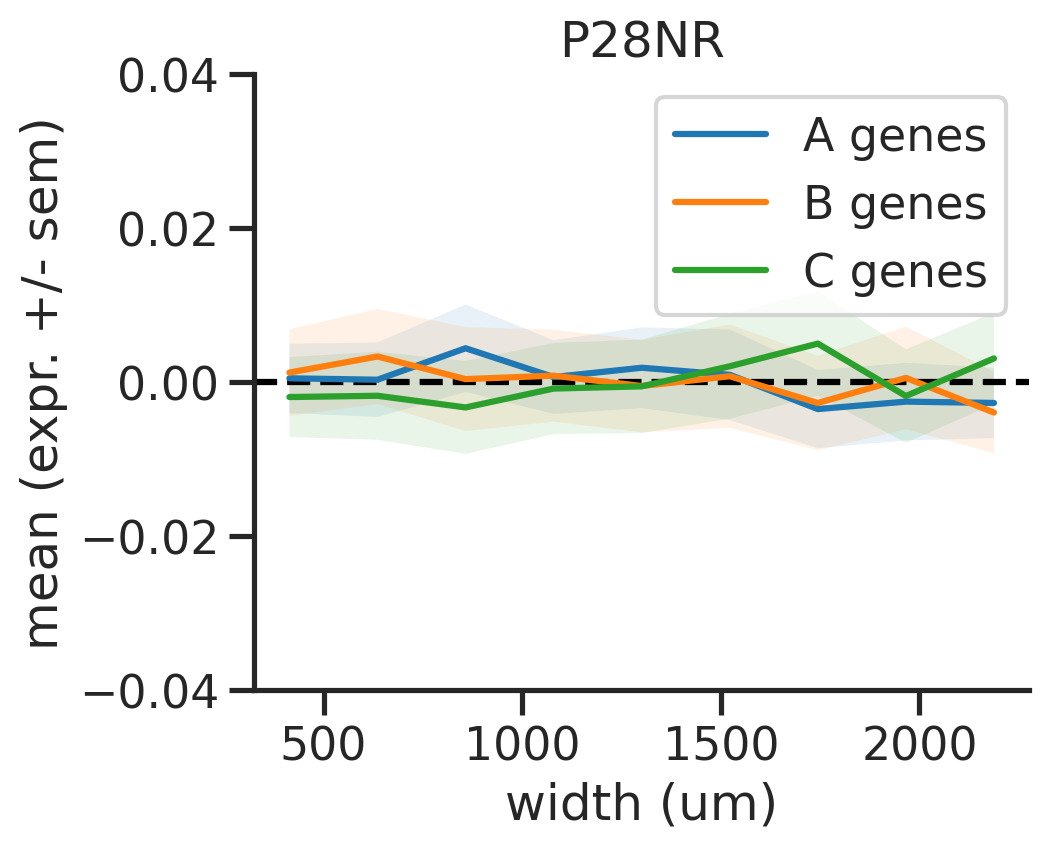

In [82]:
gnames = ['A genes (n=64)', 'B genes (n=35)', 'C genes (n=71)']
x = np.mean(np.vstack([wb[:-1], wb[1:]]), axis=0)

fig, ax = plt.subplots(1, 1, figsize=(5*1,4), sharex=True, sharey=True)

ax.plot(x, amean, label='A genes', color='C0', linestyle='-')
ax.fill_between(x, amean-asem, amean+asem, color='C0', alpha=0.1, edgecolor='none')
ax.plot(x, bmean, label='B genes', color='C1', linestyle='-')
ax.fill_between(x, bmean-bsem, bmean+bsem, color='C1', alpha=0.1, edgecolor='none')
ax.plot(x, cmean, label='C genes', color='C2', linestyle='-')
ax.fill_between(x, cmean-csem, cmean+csem, color='C2', alpha=0.1, edgecolor='none')
ax.axhline(color='k', linestyle='--', zorder=1)
    
ax.legend(bbox_to_anchor=(1,1))
sns.despine(ax=ax)
ax.set_title('P28NR')
ax.set_xlabel('width (um)')


ax.set_ylim([-0.04, 0.04])
ax.grid(False)
    
# ax.set_xlim(xmax=400)
ax.set_ylabel('mean (expr. +/- sem)')
fig.subplots_adjust(wspace=0.1)
# powerplots.savefig_autodate(fig, outdatadir+'/grant_saumya_lineq_abc_v3.pdf')